In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d")

print(latest_date)

2017-08-23 00:00:00


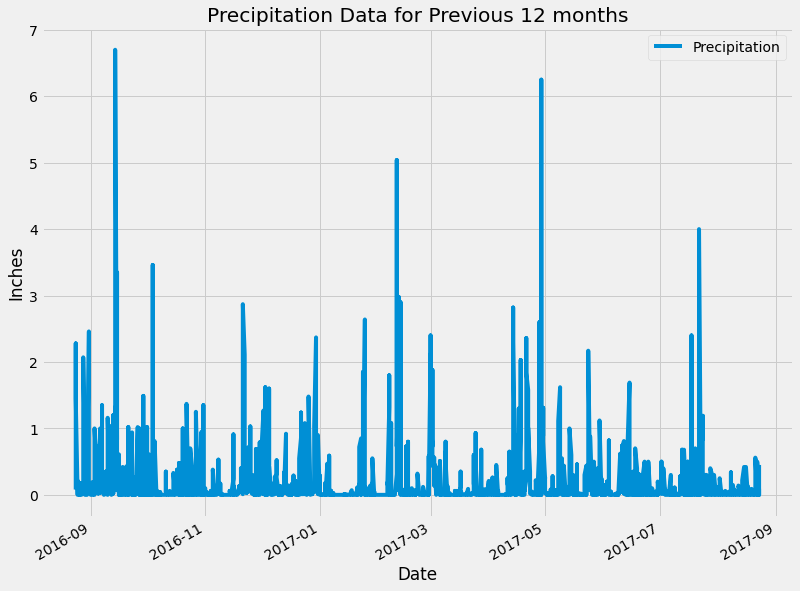

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_and_precipitation_scores = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date > date_one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
data_and_precipitation_scores_df = pd.DataFrame(data_and_precipitation_scores, columns=["Date", "Precipitation"])
data_and_precipitation_scores_df["Date"] = pd.to_datetime(data_and_precipitation_scores_df["Date"])
data_and_precipitation_scores_df = data_and_precipitation_scores_df.set_index("Date")

# Sort the dataframe by date
data_and_precipitation_scores_df = data_and_precipitation_scores_df.sort_values("Date").dropna()

# Use Pandas Plotting with Matplotlib to plot the data
data_and_precipitation_scores_df.plot(figsize=(12, 10))
plt.title("Precipitation Data for Previous 12 months")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.savefig("Images/precipitation.png")

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
data_and_precipitation_scores_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number stations in the dataset
number_of_stations = session.query(Station).count()

print(f"The Total Number of Stations = {number_of_stations}")

The Total Number of Stations = 9


In [28]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = (
    session.query(Measurement.station, Station.name, func.count(Measurement.id))
    .filter(Measurement.station == Station.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())
    .all()
)
print("The most active stations are:")
pprint(most_active_stations)

The most active stations are:
[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


# The station id that has the greatest number of observations is: USC00519281

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps_record = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active_stations[0][0])
    .all()
)

print(
    f"The most active station is {most_active_stations[0][0]} - {most_active_stations[0][1]}. The lowest, highest, and average temperatures for the most-active station are as follows:"
)
print(f"The Lowest Temperature is: {temps_record[0][0]}F")
print(f"The Highest Temperature is: {temps_record[0][1]}F")
print(f"The Average Temperature is: {temps_record[0][2]}F")

The most active station is USC00519281 - WAIHEE 837.5, HI US. The lowest, highest, and average temperatures for the most-active station are as follows:
The Lowest Temperature is: 54.0F
The Highest Temperature is: 85.0F
The Average Temperature is: 71.66378066378067F


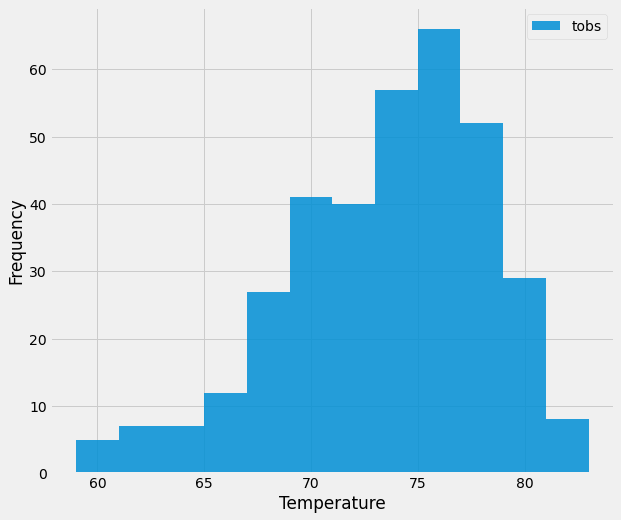

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_results = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date > date_one_year_ago)
    .filter(Measurement.station == most_active_stations[0][0])
    .order_by(Measurement.date)
    .all()
)

# Converting query object to dataframe
temperature_df = pd.DataFrame(station_results)
temperature_df = temperature_df.set_index("date").sort_index(ascending=True)


# Plot Results as Histogram
temperature_df.plot(kind="hist", bins=12, alpha=0.85, figsize=(9, 8))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("Images/station-histogram.png")

# Close session

In [33]:
# Close Session
session.close()